In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
# Load the scores files
scr_files = [
    'scores/scores_1617483922.csv', # train
    'scores/scores_1617535515.csv', # test epoch 1 model
    'scores/scores_1617536434.csv', # test epoch 2 model
    'scores/scores_1617538112.csv', # test epoch 3 model
    'scores/scores_1617533286.csv'  # test epoch 4 model
]
scrs = []
for scr_file in scr_files:
    df = pd.read_csv(scr_file, delimiter=',')
    scrs.append(df)

In [3]:
# Load the losses files
loss_files = [
    'scores/batch_losses_1617483923.csv', # train
    'scores/batch_losses_1617535515.csv', # test epoch 1 model
    'scores/batch_losses_1617536434.csv', # test epoch 2 model
    'scores/batch_losses_1617538112.csv', # test epoch 3 model
    'scores/batch_losses_1617533286.csv'  # test epoch 4 model
]
losses = []
for loss_file in loss_files:
    df = pd.read_csv(loss_file, delimiter=',')
    losses.append(df.T)

In [19]:
#print((losses[1][:].T)[0])
print(losses[4])
print(len(losses))

            0
0    0.027388
1    0.024312
2    0.022790
3    0.023062
4    0.021545
..        ...
932  0.017827
933  0.017818
934  0.017817
935  0.017822
936  0.017821

[937 rows x 1 columns]
5


In [5]:
# Add cumulative scores
cols = ['tp', 'tn', 'fp', 'fn']
for scr in scrs:
    for col in cols:
        n_col = 'sum_' + col
        scr[n_col] = scr[col].cumsum()
    scr['sum_precision'] = (scr['sum_tp'] / (scr['sum_tp'] + scr['sum_fp'] + 1e-12))
    scr['sum_recall'] = (scr['sum_tp'] / (scr['sum_tp'] + scr['sum_fn'] + 1e-12))
    scr['sum_f_score'] = (2 * scr['sum_precision'] * scr['sum_recall'])/(scr['sum_precision'] + scr['sum_recall'])

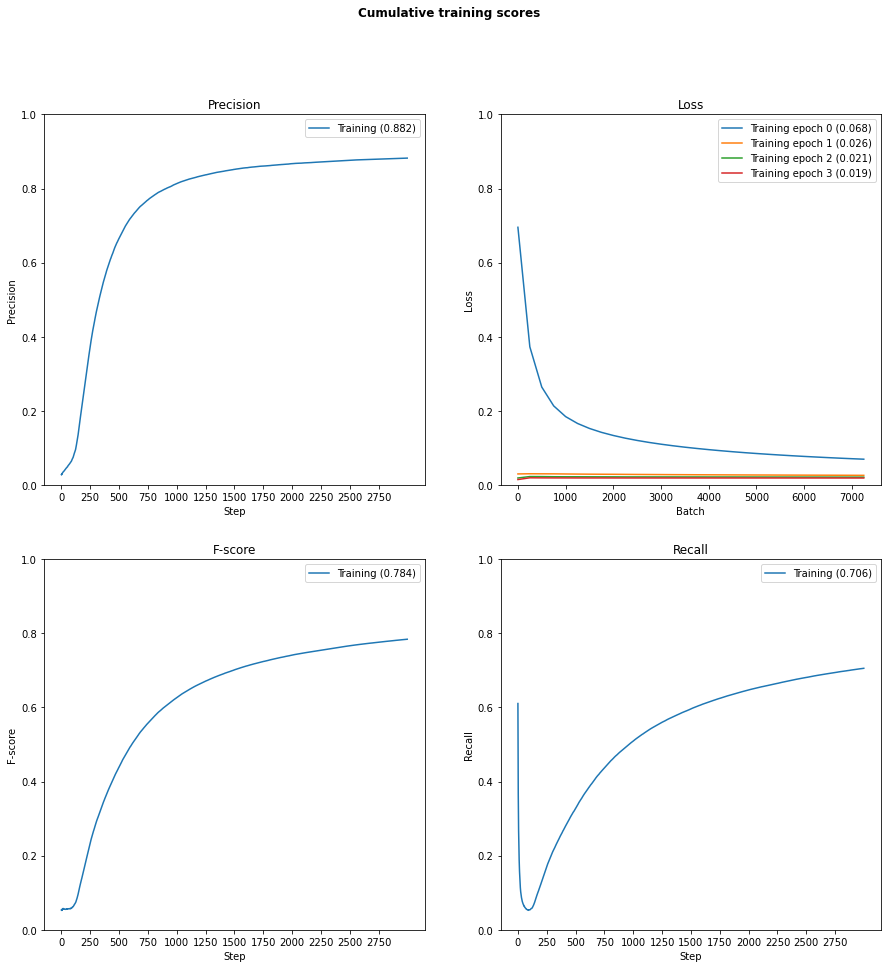

In [10]:
# TRAINING SCORES
b = 0
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['savefig.facecolor'] = 'white'
fig, ((pre_ax, los_ax), (fsc_ax, rec_ax)) = plt.subplots(2, 2)
fig.suptitle('Cumulative training scores',fontweight = "bold")
pre_ax.title.set_text('Precision')
pre_ax.set_ylim(0.0, 1.0)
pre_ax.plot(scrs[0].sum_precision, label = f'Training ({round(scrs[0].sum_precision.iloc[-1], 3)})')
pre_ax.set_xticks(list(scrs[0].index)[0::250])
pre_ax.set_xticklabels(list(scrs[0].index)[0::250])
pre_ax.set_xlabel('Step')
pre_ax.set_ylabel('Precision')
pre_ax.legend()
los_ax.title.set_text('Loss')
los_ax.set_ylim(0.0, 1.0)
i = b
while i < len(losses[0].T):
    los_ax.plot(losses[0][i][0::250], label = f'Training epoch {i} ({round(losses[0][i].iloc[-1], 3)})')
    i += 1
los_ax.set_xticks(list(losses[0][0].index)[0::1000])
los_ax.set_xticklabels(list(losses[0][0].index)[0::1000])
los_ax.set_xlabel('Batch')
los_ax.set_ylabel('Loss')
los_ax.legend()
rec_ax.title.set_text('Recall')
rec_ax.set_ylim(0.0, 1.0)
rec_ax.plot(scrs[0].sum_recall, label = f'Training ({round(scrs[0].sum_recall.iloc[-1], 3)})')
rec_ax.set_xticks(list(scrs[0].index)[0::250])
rec_ax.set_xticklabels(list(scrs[0].index)[0::250])
rec_ax.set_xlabel('Step')
rec_ax.set_ylabel('Recall')
rec_ax.legend()
fsc_ax.title.set_text('F-score')
fsc_ax.set_ylim(0.0, 1.0)
fsc_ax.plot(scrs[0].sum_f_score, label = f'Training ({round(scrs[0].sum_f_score.iloc[-1], 3)})')
fsc_ax.set_xticks(list(scrs[0].index)[0::250])
fsc_ax.set_xticklabels(list(scrs[0].index)[0::250])
fsc_ax.set_xlabel('Step')
fsc_ax.set_ylabel('F-score')
fsc_ax.legend()
fig.savefig('scores/training-scores')

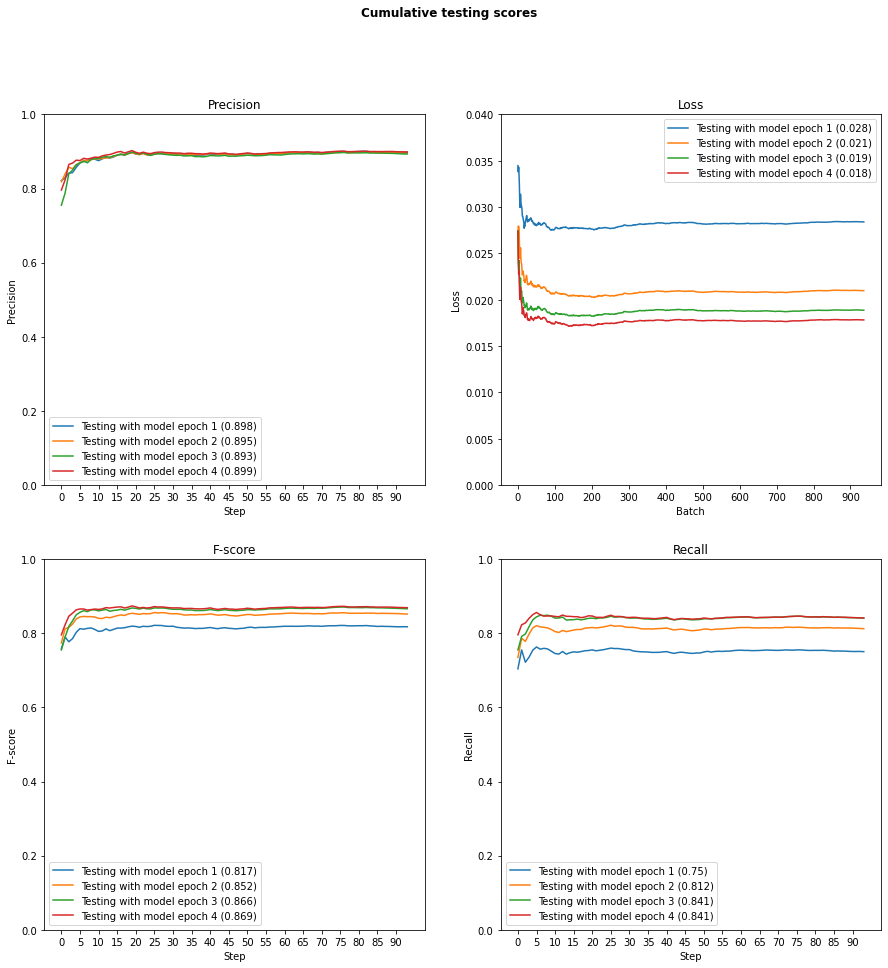

In [33]:
# Testing SCORES
s = 1
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['savefig.facecolor'] = 'white'
fig, ((pre_ax, los_ax), (fsc_ax, rec_ax)) = plt.subplots(2, 2)
fig.suptitle('Cumulative testing scores',fontweight = "bold")
pre_ax.title.set_text('Precision')
pre_ax.set_ylim(0.0, 1.0)
i = s
while i < len(scrs):
    pre_ax.plot(scrs[i].sum_precision, label = f'Testing with model epoch {i} ({round(scrs[i].sum_precision.iloc[-1], 3)})')
    i += 1
pre_ax.set_xticks(list(scrs[s].index)[0::5])
pre_ax.set_xticklabels(list(scrs[s].index)[0::5])
pre_ax.set_xlabel('Step')
pre_ax.set_ylabel('Precision')
pre_ax.legend()
los_ax.title.set_text('Loss')
los_ax.set_ylim(0.0, 0.04)
i = s
while i < len(losses):
    los_ax.plot(losses[i], label = f'Testing with model epoch {i} ({round(float(losses[i].iloc[-1]), 3)})')
    i += 1
los_ax.set_xticks(list(losses[s].index)[0::100])
los_ax.set_xticklabels(list(losses[s].index)[0::100])
los_ax.set_xlabel('Batch')
los_ax.set_ylabel('Loss')
los_ax.legend()
rec_ax.title.set_text('Recall')
rec_ax.set_ylim(0.0, 1.0)
i = s
while i < len(scrs):
    rec_ax.plot(scrs[i].sum_recall, label = f'Testing with model epoch {i} ({round(scrs[i].sum_recall.iloc[-1], 3)})')
    i += 1
rec_ax.set_xticks(list(scrs[s].index)[0::5])
rec_ax.set_xticklabels(list(scrs[s].index)[0::5])
rec_ax.set_xlabel('Step')
rec_ax.set_ylabel('Recall')
rec_ax.legend()
fsc_ax.title.set_text('F-score')
fsc_ax.set_ylim(0.0, 1.0)
i = s
while i < len(scrs):
    fsc_ax.plot(scrs[i].sum_f_score, label = f'Testing with model epoch {i} ({round(scrs[i].sum_f_score.iloc[-1], 3)})')
    i += 1
fsc_ax.set_xticks(list(scrs[s].index)[0::5])
fsc_ax.set_xticklabels(list(scrs[s].index)[0::5])
fsc_ax.set_xlabel('Step')
fsc_ax.set_ylabel('F-score')
fsc_ax.legend()
fig.savefig('scores/testing-scores')